In [1]:
%reload_ext autoreload
%autoreload 2

# Imports

In [2]:
from kret_notebook import *  # NOTE import first
from kret_matplotlib.mpl_nb_imports import *
from kret_np_pd.np_pd_nb_imports import *
from kret_polars.polars_nb_imports import *
from kret_rosetta.rosetta_nb_imports import *
from kret_sklearn.sklearn_nb_imports import *
from kret_torch_utils.torch_nb_imports import *
from kret_lightning.lightning_nb_imports import *
from kret_tqdm.tqdm_nb_imports import *
from kret_type_hints.types_nb_imports import *
from kret_utils.utils_nb_imports import *

# from kret_wandb.wandb_nb_imports import *  # NOTE this is slow to import

[kret_np_pd.np_pd_nb_imports] Imported kret_np_pd.np_pd_nb_imports in 0.0228 seconds
Loaded environment variables from /Users/Akseldkw/coding/projects_kretsinger/.env
[kret_matplotlib.mpl_nb_imports] Imported kret_matplotlib.mpl_nb_imports in 0.0850 seconds
[kret_polars.polars_nb_imports] Imported kret_polars.polars_nb_imports in 0.1027 seconds
[kret_rosetta.rosetta_nb_imports] Imported kret_rosetta.rosetta_nb_imports in 0.0000 seconds
[kret_sklearn.sklearn_nb_imports] Imported kret_sklearn.sklearn_nb_imports in 0.1551 seconds
[kret_torch_utils.torch_nb_imports] Imported kret_torch_utils.torch_nb_imports in 0.3924 seconds
[kret_lightning.lightning_nb_imports] Imported kret_lightning.lightning_nb_imports in 0.0012 seconds
[kret_tqdm.tqdm_nb_imports] Imported kret_tqdm.tqdm_nb_imports in 0.0000 seconds
[kret_type_hints.types_nb_imports] Imported kret_type_hints.types_nb_imports in 0.0011 seconds
[kret_utils.utils_nb_imports] Imported kret_utils.utils_nb_imports in 0.0006 seconds


In [3]:
from projects.beijing.beijing_datamodule import BeijingDataModule
from projects.beijing.beijing_models import BeijingAirQualityLSTM
from projects.beijing.load_beijing_data import load_beijing_air_quality_data, get_beijing_pipeline  # project_kretsinger

# Define Pipeline

In [4]:
pipeline_x, pipeline_y = get_beijing_pipeline()

# Load Data

In [5]:
beijing_dm = BeijingDataModule(UKS_CONSTANTS.DATA_DIR / "beijing", 24, (pipeline_x, pipeline_y))
beijing_dm.set_dataloader_args(batch_size=64, num_workers=4)

Saving hparams, ignoring ('pipeline_pd',)


# Implementation

## Instantiate model

In [6]:
# out =beijing_dm.data_preprocess()

In [7]:
beijing_dm.hparams_initial

"data_dir":        /Users/Akseldkw/coding/data_kretsinger/beijing
"sequence_length": 24
"split":           None

In [8]:
beijing_lstm = BeijingAirQualityLSTM(seq_length=beijing_dm.hparams_initial.sequence_length)
beijing_lstm.hparams_initial

Saving hparams, ignoring ()


"gamma":      0.5
"l1_penalty": 0.0
"l2_penalty": 0.0
"lr":         0.001
"patience":   10
"stepsize":   12

In [9]:
logger = CSVLogger(**beijing_lstm.save_load_logging_dict)

In [10]:
static_args = TrainerStaticDefaults.TRAINER_QUICK_ITER
static_args

{'min_epochs': 5,
 'max_epochs': 5,
 'check_val_every_n_epoch': 1,
 'log_every_n_steps': 10,
 'limit_val_batches': 0.1,
 'limit_test_batches': 0.1}

In [11]:
static_args["max_epochs"] = 6

In [12]:
dynamic_args = TrainerDynamicDefaults.trainer_dynamic_defaults(beijing_lstm, beijing_dm)
dynamic_args

{'logger': <lightning.pytorch.loggers.csv_logs.CSVLogger at 0x17c7d4920>,
 'default_root_dir': PosixPath('/Users/Akseldkw/coding/data_kretsinger/lightning_logs/BeijingAirQualityLSTM/v_000')}

In [13]:
trainer_args = static_args | dynamic_args

In [14]:
trainer = L.Trainer(**trainer_args)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


## Train Model

In [15]:
raise ValueError("Stop here")  # STOP

ValueError: Stop here

In [16]:
trainer.fit(model=beijing_lstm, datamodule=beijing_dm)  # , ckpt_path=beijing_lstm.ckpt_file_name())

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
/Users/Akseldkw/micromamba/envs/kret_312/lib/python3.12/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory /Users/Akseldkw/coding/data_kretsinger/lightning_logs/BeijingAirQualityLSTM/v_000 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!


Setting up data for stage: TrainerFn.FITTING
Removed 2067 rows, representing 4.72% of the data
[ColumnTransformer] ...... (1 of 3) Processing datetime, total=   0.0s
[ColumnTransformer] ........ (2 of 3) Processing scaler, total=   0.1s
[ColumnTransformer] ..... (3 of 3) Processing windlabel, total=   0.0s
Setting up data for stage: validate
Removed 2067 rows, representing 4.72% of the data


/Users/Akseldkw/micromamba/envs/kret_312/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:881: Checkpoint directory /Users/Akseldkw/coding/data_kretsinger/lightning_logs/BeijingAirQualityLSTM/v_000 exists and is not empty.


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type       ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ wind_embedding │ Embedding  │     32 │ train │     0 │
│ 1 │ lstm           │ LSTM       │ 55.8 K │ train │     0 │
│ 2 │ model          │ Sequential │  6.3 K │ train │     0 │
└───┴────────────────┴────────────┴────────┴───────┴───────┘

Trainable params: 62.1 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 62.1 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 10                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

Metric val_loss improved. New best score: 0.043
Epoch 0, global step 522: 'val_loss' reached 0.04299 (best 0.04299), saving model to '/Users/Akseldkw/coding/data_kretsinger/lightning_logs/BeijingAirQualityLSTM/v_000/best-epoch=00-val_loss=0.04.ckpt' as top 1


Epoch 1, global step 1044: 'val_loss' was not in top 1


Epoch 2, global step 1566: 'val_loss' was not in top 1


Epoch 3, global step 2088: 'val_loss' was not in top 1


Metric val_loss improved by 0.013 >= min_delta = 0.0001. New best score: 0.030
Epoch 4, global step 2610: 'val_loss' reached 0.02964 (best 0.02964), saving model to '/Users/Akseldkw/coding/data_kretsinger/lightning_logs/BeijingAirQualityLSTM/v_000/best-epoch=04-val_loss=0.03.ckpt' as top 1


Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 0.023
Epoch 5, global step 3132: 'val_loss' reached 0.02322 (best 0.02322), saving model to '/Users/Akseldkw/coding/data_kretsinger/lightning_logs/BeijingAirQualityLSTM/v_000/best-epoch=05-val_loss=0.02.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=6` reached.


## Load Model

In [17]:
checkpoint_path = beijing_lstm.ckpt_file_name()
checkpoint_path

PosixPath('/Users/Akseldkw/coding/data_kretsinger/lightning_logs/BeijingAirQualityLSTM/v_000/best-epoch=05-val_loss=0.02.ckpt')

In [26]:
beijing_lstm_load = BeijingAirQualityLSTM.load_from_checkpoint(
    checkpoint_path, map_location="mps", strict=True, weights_only=False
)

Saving hparams, ignoring ()


In [29]:
beijing_lstm_load.hparams_initial

"gamma":      0.5
"l1_penalty": 0.0
"l2_penalty": 0.0
"lr":         0.001
"patience":   10
"stepsize":   12

In [30]:
beijing_lstm.hparams_initial

"gamma":      0.5
"l1_penalty": 0.0
"l2_penalty": 0.0
"lr":         0.001
"patience":   10
"stepsize":   12

# Plot Results

In [31]:
# _ = beijing_dm.data_preprocess()

In [32]:
tensor_temporal =
    beijing_dm.val_dataloader(), sequence_length=beijing_dm.sequence_length, target_offset=0
)

In [ ]:
y_val = tensor_temporal.tensors[1].to(beijing_lstm.device)
y_val.shape

torch.Size([41733, 1])

In [ ]:
y_hat = beijing_lstm_load(tensor_temporal.tensors[0].to(beijing_lstm.device))

RuntimeError: Placeholder storage has not been allocated on MPS device!

In [ ]:
r2_score_pt(y_hat, y_val)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, mps:0 and cpu!

In [ ]:
fig, ax = UKS_MPL.subplots(1, 1)

In [ ]:
ax.plot(y_val.numpy(force=True), y_hat.numpy(force=True), linestyle="", marker="o", alpha=0.1)

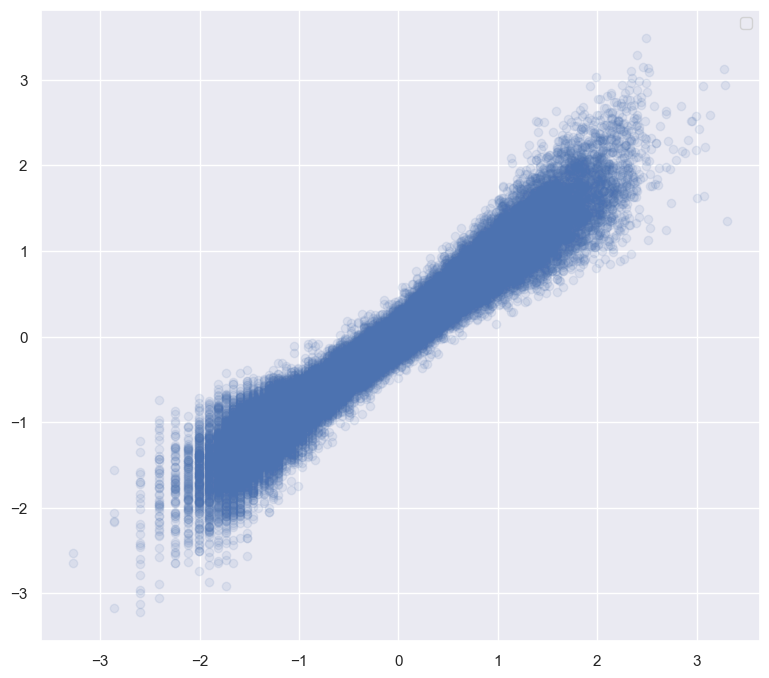

In [ ]:
fig

# Sandbox

In [ ]:
from kret_matplotlib.groupscatter import GroupScatter

In [ ]:
ones = np.ones_like(y_val.squeeze(-1).numpy(force=True))
random_ints = np.random.randint(0, 5, size=y_val.shape[0])

In [ ]:
gs = GroupScatter(y_val, y_hat, random_ints, regression_func="Huber")

In [ ]:
type(gs._df_input.category)

pandas.core.series.Series

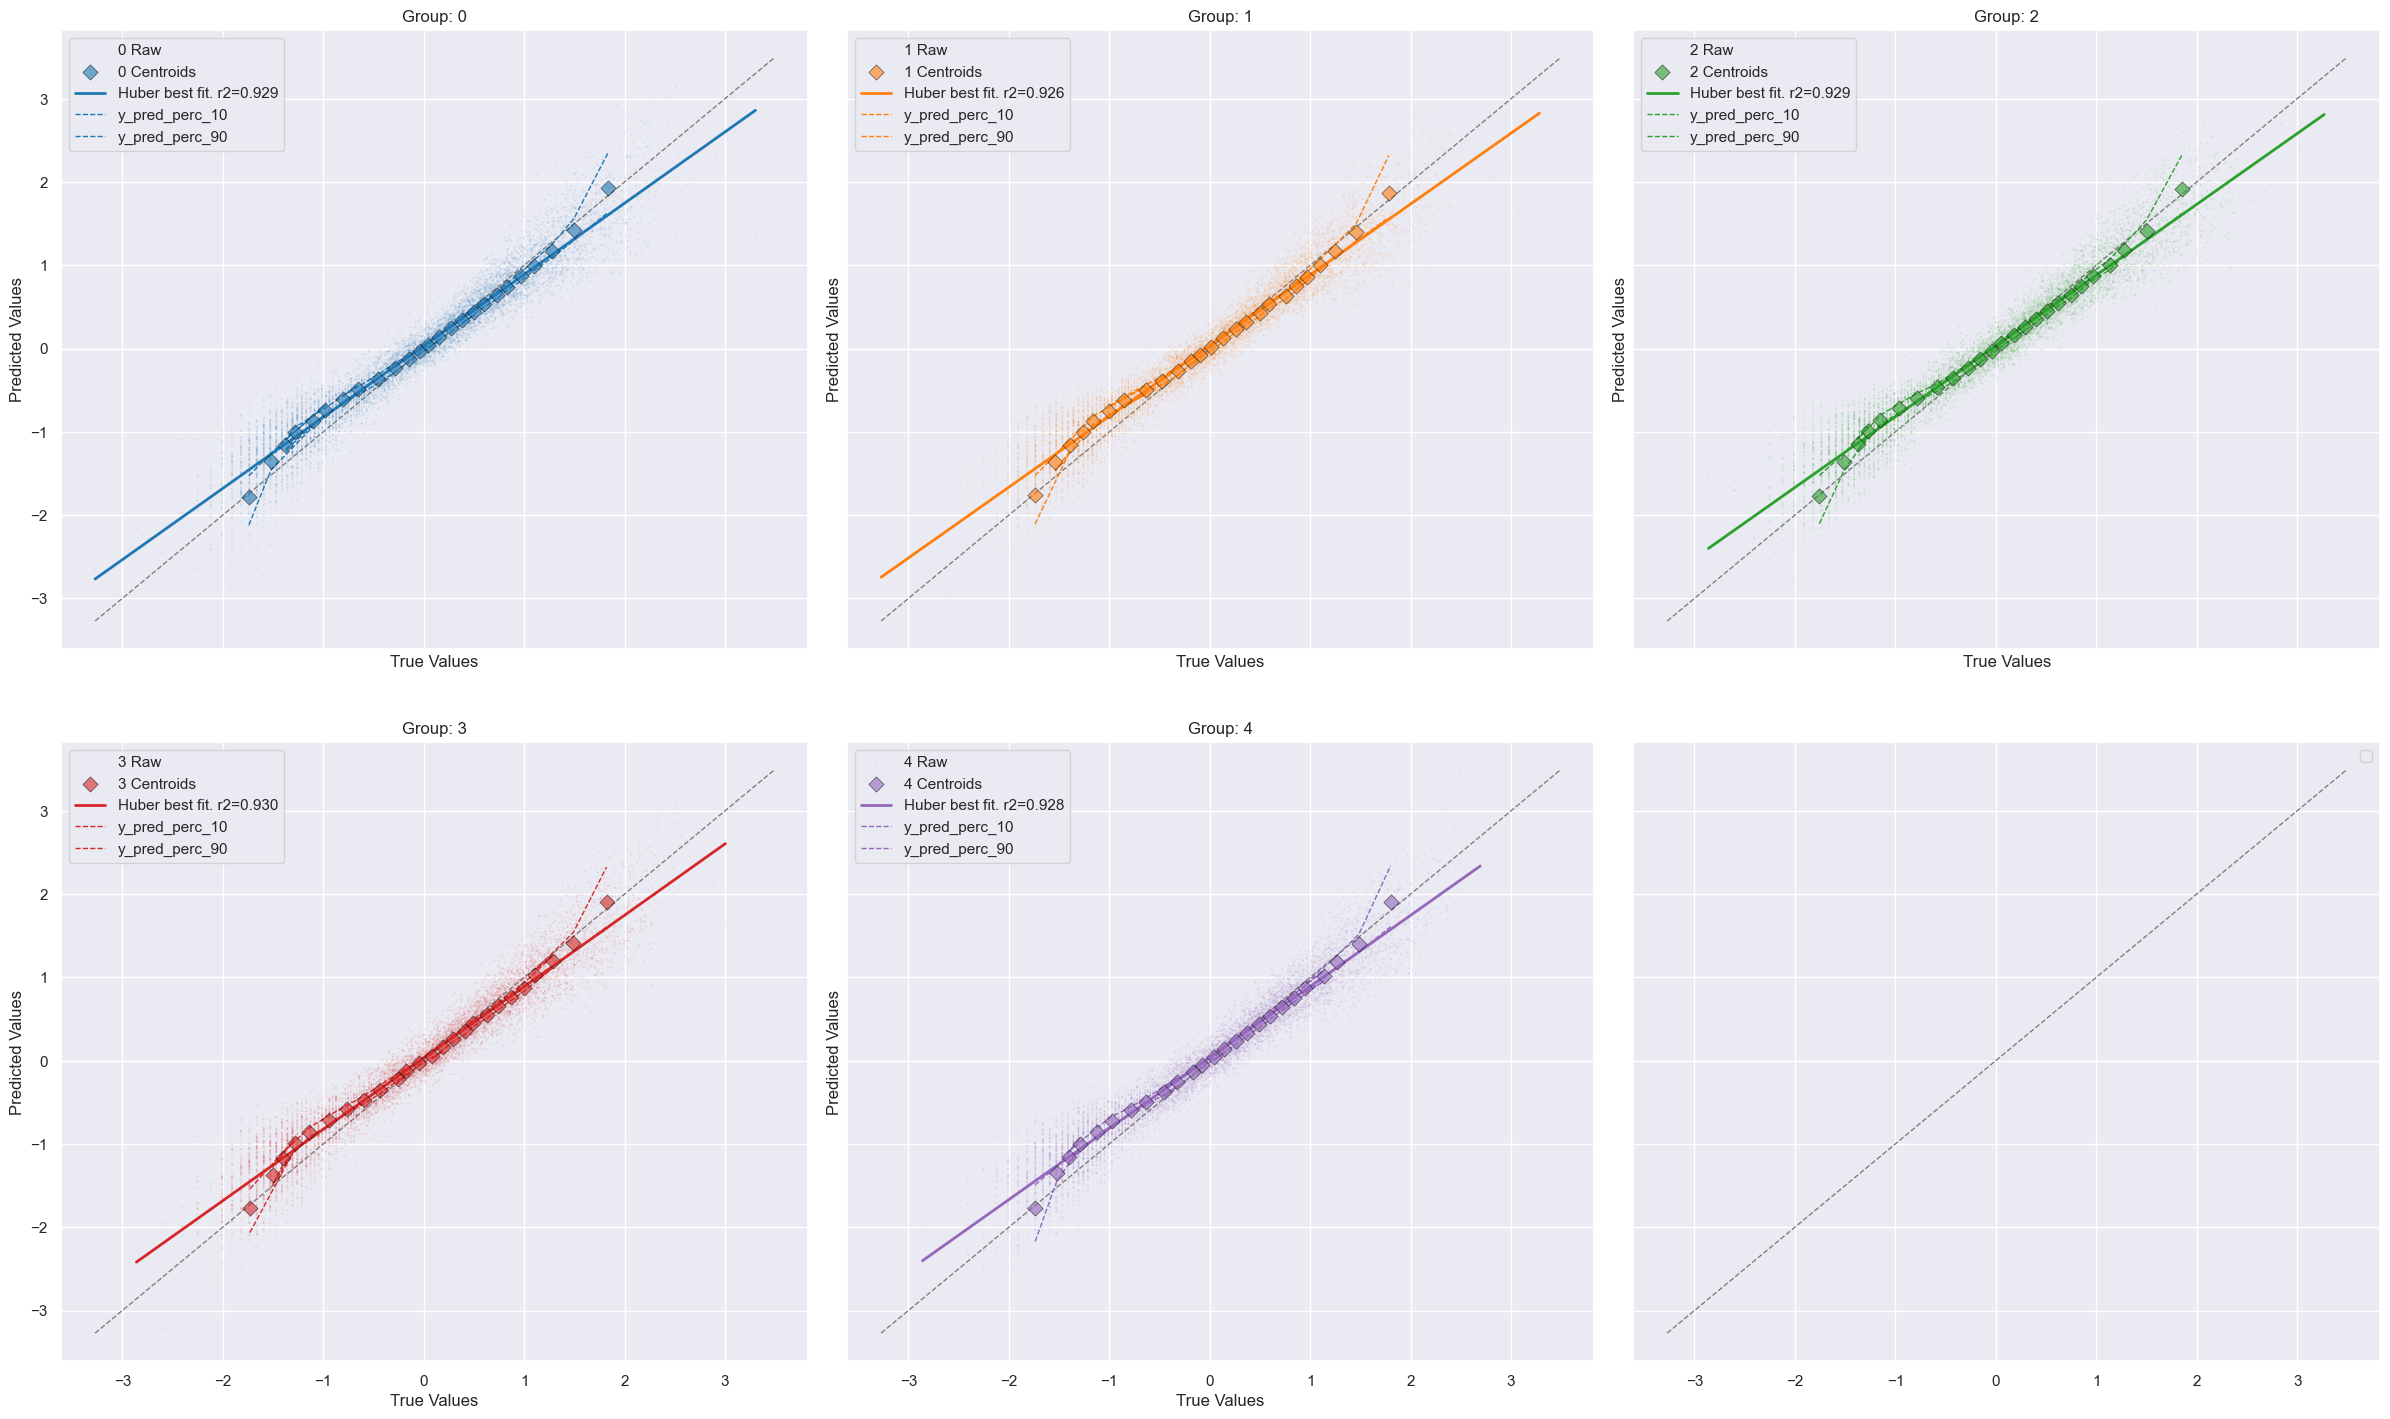

In [ ]:
gs.plot(ax="separate", scatters=("centroids", "raw"), percentiles=(10,))

In [ ]:
r2 = r2_score_pt(y_hat, y_val).item()

In [ ]:
f"{r2:.3f}"

'0.928'